<a href="https://colab.research.google.com/github/Shaielyfs/Classifica_de_Uso_e_Cobertura_do_Solo_Sentinel-2_GEE_ML/blob/main/clas_uso_solo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Land Use and Land Cover (LULC) Classification with Machine Learning

Objetivo:Desenvolver um pipeline completo para mapeamento de Uso e Cobertura do Solo (LULC) utilizando imagens Sentinel-2 obtidas via Google Earth Engine, processadas no Google Colab e classificadas com Machine Learning (Random Forest).

In [1]:
# instalar google earth engine
!pip install geemap rasterio scikit-learn matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


In [2]:
# ativar o GEE
import geemap
import ee
ee.Authenticate()     #autenticar a conta
ee.Initialize(project="classi-uso-e-cobertura-do-solo")

In [3]:
# definir área de estudo
roi = ee.Geometry.Polygon(
    [[-48.58867069419273,-25.700372792794713],
      [-48.338045083841166,-25.700372792794713],
      [-48.338045083841166,-25.497880231775763],
      [-48.58867069419273,-25.497880231775763],
      ])

image = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(roi)
    .filterDate("2023-01-01", "2023-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
    .median()
    .clip(roi)
)

In [20]:
# selecionar as bandas
bands = ['B2', 'B3', 'B4', 'B8']
# Azul (água, atm), Verde (vegetação), Vermelho (vegetação, solo), NIR (biomassa vegetal)

# índices espectrais que realçam padrões ambientais
#vegetação NDVI = (NIR - Red)/(NIR + Red)
#corpos d'água  NDWI = (Green - NIR)/(Green + NIR)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

image = image.select(bands).addBands(ndvi).addBands(ndwi)

In [21]:
#exportar a imagem para o colab
import os

output_dir = "data/raw"
# Criar o diretório se ele não existir
os.makedirs(output_dir, exist_ok=True)

geemap.ee_export_image(
    image,
    filename=os.path.join(output_dir, "sentinel_2.tif"),
    scale=30,        # Aumentar a escala para reduzir o tamanho do arquivo
    region=roi,      #área de estudo
    file_per_band=False    #tudo em único GeoTIFF
)

Generating URL ...
Please wait ...
Data downloaded to /content/data/raw/sentinel_2.tif


In [6]:
#verificando a exportação
import rasterio

filename = "data/raw/sentinel_2.tif" # Definir a variável filename

with rasterio.open(filename) as src:
    print(src.count)       #n de banda
    print(src.shape)       #dimensão
    print(src.crs)         #sist de coorden

5
(753, 931)
EPSG:4326


In [22]:
#importar as amostras geradas no GEE
import pandas as pd

samples = pd.read_csv("/content/drive/MyDrive/training_samples.csv")

X = samples.drop(columns=['class'])
y = samples['class']

In [23]:
#Treinamento e validação do com Machine Learning
#importar as bibliotecas
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
#Ler as amostras
samples = pd.read_csv("/content/drive/MyDrive/training_samples.csv")

samples.head()


,system:index,B2,B3,B4,B8,NDVI,NDWI,class,.geo
0,1_1_1_0_0,132.0,119.0,117.0,63.0,-0.300000,0.307692,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_1_0_1,131.0,127.0,135.0,58.0,-0.398964,0.372973,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_1_1_0_2,207.0,246.0,192.0,108.0,-0.280000,0.389831,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_1_1_0_3,210.0,275.0,190.0,105.0,-0.288136,0.447368,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_1_1_0_4,122.0,156.0,163.0,274.0,0.254005,-0.274419,1,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [25]:
#separar variáveis e rótulos , eliminar coluna geo e system:index
X = samples.drop(columns=['class', '.geo', 'system:index'])
y = samples['class']

In [26]:
#dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      #30% para teste
    random_state=42,    #Controla a aleatoriedade da divisão
    stratify=y          #mantém proporção das classes
)

In [27]:
#treinar o randon forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [28]:
#avaliar o modelo
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.83      1.00      0.91         5
           4       1.00      0.75      0.86         4

    accuracy                           0.94        18
   macro avg       0.96      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18



In [29]:
#abrir a imagem multibandas
image_path = "data/raw/sentinel_2.tif"

with rasterio.open(image_path) as src:
    img = src.read()
    profile = src.profile


In [34]:
#preparar matriz de entrada para o modelo
bands, rows, cols = img.shape

X_image = img.reshape(bands, rows * cols).T


In [35]:
#classificar todos os pixels

classified = rf.predict(X_image)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [37]:
#reconstruir a imagem classificada
classified_img = classified.reshape(rows, cols)


In [40]:
#salvar o mapa
profile.update(
    dtype=rasterio.uint8,
    count=1
)

output_path = "/content/drive/MyDrive/Maps/UsoEocupacao_map.tif"

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(classified_img, 1)


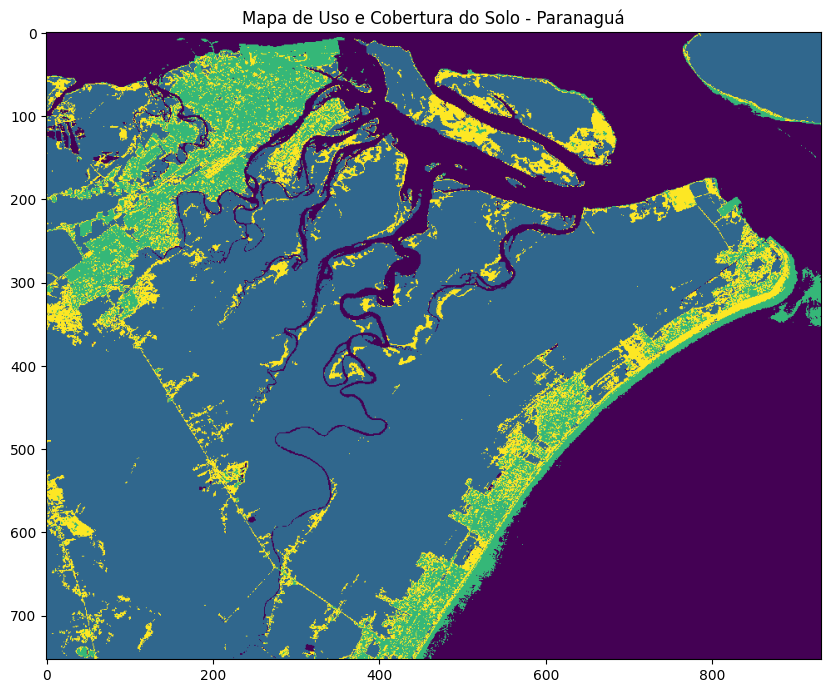

In [54]:
#visualização

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(classified_img)
plt.title("Mapa de Uso e Cobertura do Solo - Paranaguá")
plt.axis("on")

plt.show()



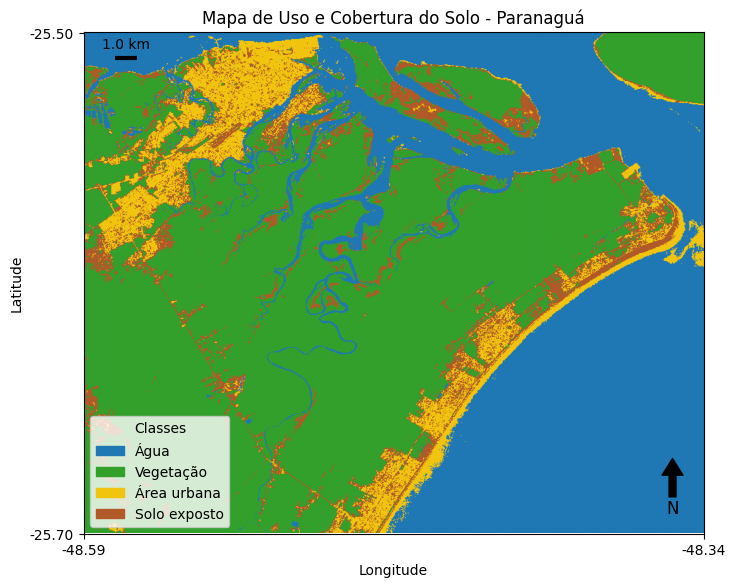

In [69]:
#Configurar a legenda

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

class_labels = {
    1: "Água",
    2: "Vegetação",
    3: "Área urbana",
    4: "Solo exposto"
}

colors = [
    "#1f78b4",  # Água
    "#33a02c",  # Vegetação
    "#F1C40F",  # Área urbana
    "#b15928"   # Solo exposto
]

cmap = ListedColormap(colors)

bounds = [1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8,8))

img = ax.imshow(classified_img, cmap=cmap, norm=norm)

legend_patches = [
    mpatches.Patch(color=colors[i-1], label=class_labels[i])
    for i in class_labels
]

ax.legend(
    handles=legend_patches,
    loc="lower left",
    frameon=True,
    title="Classes"
)
plt.title("Mapa de Uso e Cobertura do Solo - Paranaguá")

#adicionar seta N

ax.annotate(
    'N',
    xy=(0.95, 0.15),
    xytext=(0.95, 0.05),
    arrowprops=dict(facecolor='black', width=5, headwidth=15),
    ha='center',
    va='center',
    fontsize=12,
    xycoords=ax.transAxes
)

#adicionar a escala
pixel_size = 30  # Sentinel-2 é 10, mas foi adaptado para pesar menos
add_scalebar(ax, pixel_size)

#adicionar as coordenadas
with rasterio.open("/content/drive/MyDrive/Maps/UsoEocupacao_map.tif") as src:
    bounds = src.bounds

ax.set_xticks([0, classified_img.shape[1]])
ax.set_yticks([0, classified_img.shape[0]])

ax.set_xticklabels(
    [f"{bounds.left:.2f}", f"{bounds.right:.2f}"]
)
ax.set_yticklabels(
    [f"{bounds.top:.2f}", f"{bounds.bottom:.2f}"]
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


plt.show()